### Projet Uber Pickups

Dans ce projet nous allons utiliser le Machine Learning non-supervisé (clustering) pour construire un algorithme de recommandation quant aux endroits où les chauffeurs devraient se trouver pour maximiser leurs chances de trouver une course.

#### Importation des librairies qui seront utiles pour le traitement des données

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pygeocoder import Geocoder

import datetime as dt

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

import folium
import folium.plugins as plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime


from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


#### Chargement du fichier csv contenant les données dans un dataframe

In [0]:
Apr14 = pd.read_csv('uber-raw-data-apr14.csv')

In [0]:
Apr14.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [0]:
Apr14.shape

(564516, 4)

#### Preprocessing

- On utilise le module datetime pour transformer les valeurs contenues dans la colonne 'Date/Time'
- Ceci permet de récupérer les attributs day, day_name, hour, minute

In [0]:
Apr14['Date/Time'] = pd.to_datetime(Apr14['Date/Time'])

Apr14['Week_dayNum'] = Apr14['Date/Time'].dt.dayofweek
Apr14['Month_day'] = Apr14['Date/Time'].dt.day
Apr14['Week_day'] = Apr14['Date/Time'].dt.day_name()
Apr14['Hour'] = Apr14['Date/Time'].dt.hour
Apr14['minute'] = Apr14['Date/Time'].dt.minute

In [0]:
Apr14.head()

,Date/Time,Lat,Lon,Base,Week_dayNum,Month_day,Week_day,Hour,minute
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,1,Tuesday,0,11
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,1,Tuesday,0,17
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,1,Tuesday,0,21
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,1,Tuesday,0,28
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,1,Tuesday,0,33


#### Exploration du jeu de données

#### Distribution des pickups en fonction des jours du mois

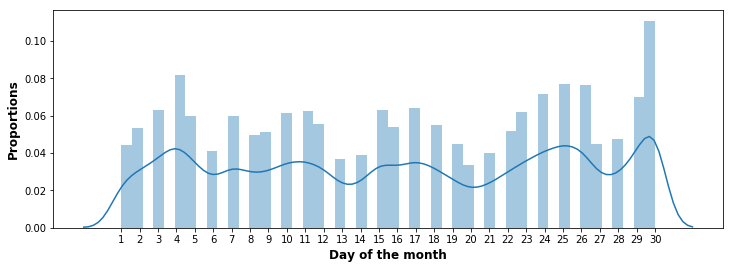

In [0]:
plt.figure(figsize=(12,4))
plt.xticks(np.arange(1, 31, step=1))
sns.distplot(Apr14.Month_day)

plt.xlabel('Day of the month', fontsize=12, fontweight='bold')
plt.ylabel('Proportions', fontsize=12, fontweight='bold')
plt.show()

- La distribution du nombre de pickups en fonction des jours du mois d'avril semble assez stable
- Deux pics sont observés au début et à la fin du mois

#### Distribution des pickups en fonction des jours de la semaine

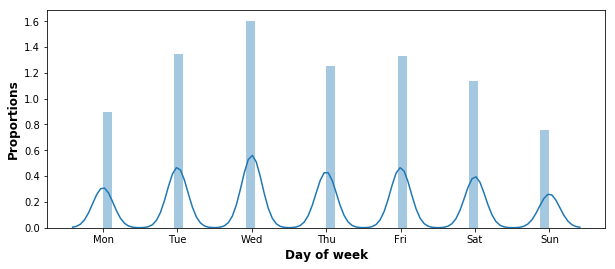

In [0]:
plt.figure(figsize=(10,4))
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
sns.distplot(Apr14.Week_dayNum)

plt.xlabel('Day of week', fontsize=12, fontweight='bold')
plt.ylabel('Proportions', fontsize=12, fontweight='bold')
plt.show()

- Le mercredi apparait comme étant le jour où on compte le plus grand nombre de pickups
- Le mardi et le vendredi arrivent juste après.
- Le Dimanche et le Lundi sont les jours où on compte le moins de pickups

#### Distribution des heures de pickups

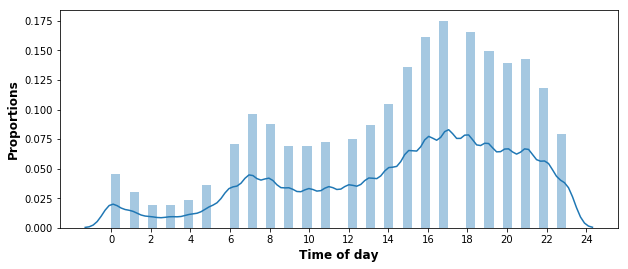

In [0]:
plt.figure(figsize=(10,4))
plt.xticks(np.arange(0, 26, step=2))
sns.distplot(Apr14.Hour)

plt.xlabel('Time of day', fontsize=12, fontweight='bold')
plt.ylabel('Proportions', fontsize=12, fontweight='bold')
plt.show()

- Le nombre de pickups augmente entre 0H et 2H, entre 6H et 7H, et entre 14h et 17H
- Les pics sont observés à 7h et à 17h, et cette dernière heure est celle ou qui cummule le plus grand nombre de pickups
- La distribution fait également ressortir 4 groupes d'horaires qu'on va créer dans une nouvelle colonne du dataset

In [0]:
Apr14['Day_time'] = Apr14.Hour.apply(lambda x: 'Night' if 0<=x<6 
                                          else 'Morning' if 6<=x<12 
                                          else 'Afternoon' if 12<=x<18
                                          else 'Evening')

In [0]:
Apr14.head()

,Date/Time,Lat,Lon,Base,Week_dayNum,Month_day,Week_day,Hour,minute,Day_time
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,1,Tuesday,0,11,Night
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,1,Tuesday,0,17,Night
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,1,Tuesday,0,21,Night
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,1,Tuesday,0,28,Night
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,1,Tuesday,0,33,Night


In [0]:
Apr14['count'] = 1
Apr14.head()

,Date/Time,Lat,Lon,Base,Week_dayNum,Month_day,Week_day,Hour,minute,Day_time,count
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,1,Tuesday,0,11,Night,1
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,1,Tuesday,0,17,Night,1
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,1,Tuesday,0,21,Night,1
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,1,Tuesday,0,28,Night,1
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,1,Tuesday,0,33,Night,1


#### Heatmap des pickups 

#### Sur l'ensemble du mois

In [0]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    month_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return month_map

month_map = generateBaseMap()
data = Apr14[['Lat', 'Lon', 'count']].groupby(['Lat', 'Lon']).sum().reset_index().values.tolist()
HeatMap(data=data, 
        radius=8, 
        gradient={0.2: 'blue', 0.6: 'lime', 0.8: 'orange', 1: 'red'},
        min_opacity=0.1, 
        max_zoom=13).add_to(month_map)

In [0]:
month_map.save("month_map.html")

#### Selon l'heure

In [0]:
df_hour_list = []
for hour in Apr14.Hour.sort_values().unique():
    df_hour_list.append(Apr14.loc[Apr14.Hour == hour, ['Lat', 'Lon','count']].groupby(['Lat', 'Lon']).sum().reset_index().values.tolist())

In [0]:
time_map = generateBaseMap()
HeatMapWithTime(df_hour_list,
                auto_play=False,
                radius=5, 
                gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, 
                max_opacity=0.8, 
                use_local_extrema=True).add_to(time_map)

In [0]:
time_map.save("time_map.html")

#### Méthode des KMeans

- On crée un nouveau dataset avec les colonnes Lat et Lon qui va nous servir pour déterminer nos clusters

In [0]:
df = Apr14.iloc[:,[1,2]]
X = df.copy()

In [0]:
X.head()

,Lat,Lon
0,40.7690,-73.9549
1,40.7267,-74.0345
2,40.7316,-73.9873
3,40.7588,-73.9776
4,40.7594,-73.9722


#### On utilise la méthode Elbow pour déterminer le nombre optimal de clusters

In [0]:
from sklearn.cluster import KMeans

wcss={}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=200, random_state=42).fit(X)
    wcss[k] = kmeans.inertia_

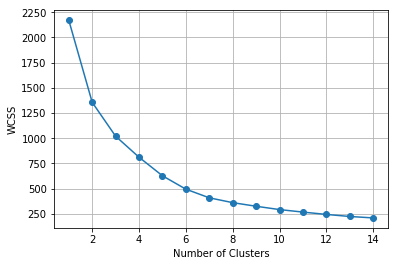

In [0]:
plt.figure()
plt.plot(list(wcss.keys()), list(wcss.values()),  marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

- A ce stade il semble que le nombre de cluster optimal est compris entre 4 et 8
- On va essayer de l'affiner en utilisant la méthode des silhouettes

#### Utilisation de la méthode des silhouettes pour affiner le nombre de clusters

In [0]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=42)  # For reproducibility

range_n_clusters = [4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

- La méthode des silhoutettes nous indique que le nombre de clusters optimal est 4

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, max_iter=200, random_state=42).fit(df)

- On regarde les centroids

In [0]:
centroids=kmeans.cluster_centers_
centroids=pd.DataFrame(centroids, columns=['Lat', 'Lon'])
centroids

,Lat,Lon
0,40.723259,-73.992233
1,40.768175,-73.965710
2,40.700735,-74.201352
3,40.678896,-73.778098


In [0]:
centroid_lat = centroids.Lat.tolist()
centroid_lon = centroids.Lon.tolist()
latlon = zip(centroid_lat, centroid_lon)
cluster_index = centroids.index.tolist()

In [0]:
pickups_map = generateBaseMap()

for coord, cluster in zip(latlon, cluster_index):
    cluster_name = 'Cluster_' + str(cluster)
    popup = folium.Popup(cluster_name, max_width=300)
    icon = folium.Icon(color='black',icon='taxi', prefix='fa')
    folium.Marker(location=[coord[0], coord[1]], popup=popup, icon=icon).add_to(pickups_map)
pickups_map

In [0]:
pickups_map.save("pickups_map.html")

In [0]:
y_kmean = kmeans.fit_predict(df)
y_kmean = pd.DataFrame(y_kmean, columns=['Cluster_geo'])

In [0]:
Apr14 = pd.concat([Apr14, y_kmean], axis=1)

In [0]:
Apr14.head()

,Date/Time,Lat,Lon,Base,Week_dayNum,Month_day,Week_day,Hour,minute,Day_time,count,Cluster_geo
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,1,Tuesday,0,11,Night,1,1
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,1,Tuesday,0,17,Night,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,1,Tuesday,0,21,Night,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,1,Tuesday,0,28,Night,1,1
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,1,Tuesday,0,33,Night,1,1


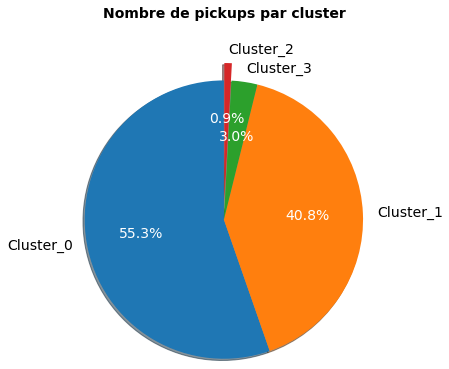

In [0]:
fig_data = Apr14['Cluster_geo'].value_counts()/Apr14['Cluster_geo'].value_counts().sum()
fig_data = fig_data.rename(index={0: 'Cluster_0', 1: 'Cluster_1', 2: 'Cluster_2', 3: 'Cluster_3'})

labels = [fig_data.index[item] for item in range(0, len(fig_data.index))]
explode = (0.0,0.0,0.0,0.2)
colors = ('#22a6b3', '#badc58')

fig, ax = plt.subplots()
_, texts, autotexts = ax.pie(fig_data, autopct='%1.1f%%', shadow=True, startangle=90, explode=explode, labels=labels, radius=1.6)
#fig.legend(fig_data.index, loc="center left")

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_size('14')

for text in texts:
    text.set_size('14')

ax.set_title("Nombre de pickups par cluster", y=1.4, fontsize = 14, fontweight='bold')
plt.show()

- L'ile de Manhattan (Cluster_0 et Cluster_1) dénombre le plus grand nombre de pickups
- Peut-être rediriger les chauffeurs vers le Cluster_2 (aéroport de Newark) et le Cluster_3 (aéroport John Kennedy)
- Cette décision dépend de la demande et de la concurrence, données nécessaire pour orienter les chauffeurs vers les meilleurs endroits

#### Heatmap de l'ensemble du mois avec les centroids

- Zones de pickup les plus prisées en fonction du 'Day_of_week' ?
- Pour le 'Day_of_week' le plus prisé, quelle est le 'Day_time' le plus prisé ?
- Zones de pickup les plus prisées en fonction du 'Day_time'

In [0]:
centroids = kmeans.cluster_centers_
centroids_tuples = tuple(map(tuple, centroids))
centroids_list = list(centroids_tuples)
centroids_list

[(40.72325882469451, -73.99223323760083),
 (40.76817508338341, -73.96570998336686),
 (40.700735145670905, -74.20135166187936),
 (40.678895723975224, -73.7780979828959)]

In [0]:
Apr14['count'] = 1
data = Apr14[['Lat', 'Lon', 'count']].groupby(['Lat', 'Lon']).sum().reset_index().values.tolist()

In [0]:
month_map_centroids = generateBaseMap()
HeatMap(data=data,
        radius=8,
        min_opacity=0.1,max_zoom=13).add_to(month_map_centroids)

for coord in centroids_list:
  folium.CircleMarker(location=([coord[0], coord[1]]),
                      radius=10,
                      color='darkblue',
                      fill_color='darkblue').add_to(month_map_centroids)

In [0]:
month_map_centroids.save("month_map_centroids.html")

#### Evolution des Pickups selon l'heure avec les centroids

In [0]:
df_hour_list = []
for hour in Apr14.Hour.sort_values().unique():
    df_hour_list.append(Apr14.loc[Apr14.Hour == hour, ['Lat', 'Lon','count']].groupby(['Lat', 'Lon']).sum().reset_index().values.tolist())

In [0]:
time_map_centroids = generateBaseMap()

HeatMapWithTime(df_hour_list, 
                radius=5, 
                gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, 
                max_opacity=0.8, 
                use_local_extrema=True).add_to(time_map_centroids)

for coord in centroids_list:
 folium.CircleMarker(location=([coord[0], coord[1]]),
                     radius=10,
                     color='darkblue',
                     fill_color='darkblue').add_to(time_map_centroids)

In [0]:
time_map_centroids.save("time_map_centroids.html")

#### Méthode DBSCAN

In [0]:
Apr14.head()

,Date/Time,Lat,Lon,Base,Week_dayNum,Month_day,Week_day,Hour,minute
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,1,1,Tuesday,0,11
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,1,1,Tuesday,0,17
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,1,1,Tuesday,0,21
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,1,1,Tuesday,0,28
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,1,1,Tuesday,0,33


In [0]:
len(Apr14)

564516

In [0]:
- Jeu de données trop important, temps de calcul trop long avec la méthode DBSCAN
- On va réduire le dataset, en ne gardant que les mercredis

In [0]:
df2 = Apr14.loc[(Apr14['Month_day'] == 30)]
df2 = df2.iloc[:,1:3]
df2.head()

,Lat,Lon
33350,40.7685,-73.9581
33351,40.6444,-73.7823
33352,40.7715,-73.9825
33353,40.6799,-73.9075
33354,40.7198,-73.9858


In [0]:
len(df2)

36251

In [0]:
# Paramètres DBSCAN

max_distance = 0.005 # 5 mètres entre chacun des pickups
min_pickups = 5      # 5 courses minimum afin de constituer un point

In [0]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps=max_distance, min_samples=min_pickups, n_jobs=-1).fit(df2)

In [0]:
dbsc_predict = dbsc.fit_predict(df2)
coord_dbsc = dbsc.components_

#### Clusters du DBSCAN

In [0]:
import folium
centre = [40.71427, -74.00597]
newyork = folium.Map(location=centre, zoom_start = 12)

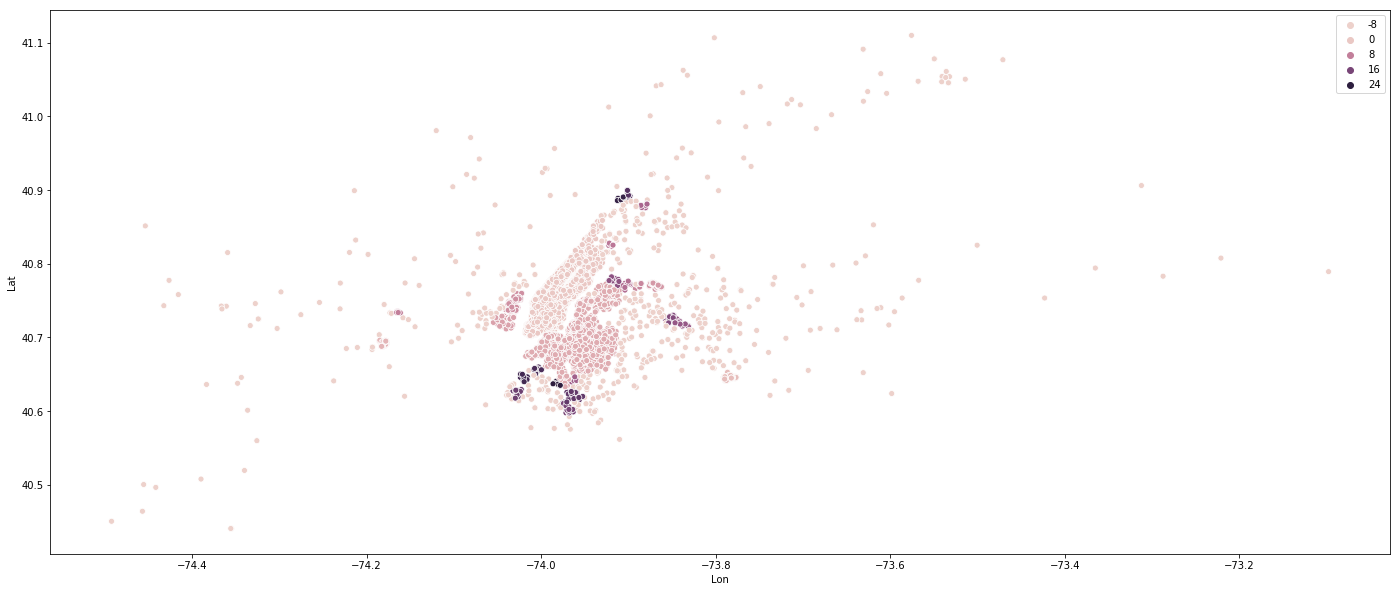

In [0]:
plt.figure(figsize=(24, 10))
sns.scatterplot(df2.iloc[:,1], df2.iloc[:, 0], hue=dbsc_predict)
newyork